In [1]:
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
from hffragDeepSetsMultivariate import PredictOnEpoch
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from hffragDeepSetsMultivariate import hffragDeepSets
from HffragDeepSetsProjection2 import DeepSetsProjection
from hffragDeepSetsMultivariate import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
import numpy_indexed as npi
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-26 18:02:48.659450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 18:02:48.819639: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-26 18:02:48.823925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-26 18:02:48.823946: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
reconstructed_jet_features = ["AnalysisJets_pt_NOSYS", "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]

In [6]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features+reconstructed_jet_features, entry_stop=MAXEVENTS)

In [13]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [14]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [15]:
# Select tracks from the events
tracks = events[track_features]
rejets = events[reconstructed_jet_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [16]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
rejets = rejets[bjets]
rejets = DSNNA.pad(rejets,MAXTRACKS)[:,0]


# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

rejets_pt = rejets["AnalysisJets_pt_NOSYS"].to_numpy()
rejets_eta = rejets["AnalysisJets_eta"].to_numpy()
rejets_phi = rejets["AnalysisJets_phi"].to_numpy()
rejets_m = rejets["AnalysisJets_m"].to_numpy()
re_b_jets = np.stack([rejets_pt,rejets_eta,rejets_phi, rejets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 inputs


In [17]:
# Transform the jet and tracks to unstructed data.
rejets = rejets.to_numpy()
rejets = structured_to_unstructured(rejets[reconstructed_jet_features])
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [18]:
rejets_pt = re_b_jets[:,0].reshape(-1,1)
rejets_eta = re_b_jets[:,1].reshape(-1,1)
rejets_phi = re_b_jets[:,2].reshape(-1,1)

re_b_jets_pep = np.concatenate([rejets_pt,rejets_eta,rejets_phi], axis = -1) 
print(re_b_jets_pep.shape)

# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
reconjet_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(re_b_jets)
b_jets = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
re_b_jets_m = re_b_jets[:,-1].reshape(-1,1)
# Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p, matchedtracks[:, :, 3:].to_numpy()], axis=2)
re_b_jets = np.concatenate([reconjet_p,re_b_jets_pep,re_b_jets_m], axis = -1)

#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)
#Mask out the MASKVALs used to pad the reconstructed jets
re_b_jets = np.ma.masked_values(re_b_jets,-999)

(68143, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:146: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [19]:
print(np.shape(tracks))
print(np.shape(b_jets))
print(np.shape(re_b_jets))
print(np.shape(bhads_pt))
#Standardize the track inputs
Scaler = StandardScaler()
Num_events, Num_tracks, Num_features = np.shape(tracks)
tracks = np.reshape(tracks, newshape=(-1, Num_features))
tracks = Scaler.fit_transform(tracks)
tracks = np.reshape(tracks, newshape=(Num_events, Num_tracks, Num_features))

(68143, 32, 8)
(68143, 3)
(68143, 7)
(68143,)


In [20]:
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
re_b_jets_mag = np.linalg.norm(re_b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/jets_pt
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((jets_m**2) + (b_jets_mag**2))
print(b_jets_energy.shape, jets_m.shape)

re_b_jets_energy = np.sqrt((re_b_jets_m[:,0]**2) + (re_b_jets_mag**2))
print(re_b_jets_energy.shape)


b_jets_energy_pt = np.sqrt((b_jets[:,0]**2) + (jets_m**2))
b_jets_energy_pt.shape


re_b_jets_energy_pt = np.sqrt((re_b_jets[:,0]**2) + (re_b_jets_m[:,0]**2))
re_b_jets_energy_pt.shape


b_jet_energy_mass_ratio = b_jets_energy/jets_m
b_jet_energy_mass_ratio[np.isinf(b_jet_energy_mass_ratio)] = np.median(b_jet_energy_mass_ratio)

re_b_jet_energy_mass_ratio = re_b_jets_energy/re_b_jets_m[:,0]
re_b_jet_energy_mass_ratio[np.isinf(re_b_jet_energy_mass_ratio)] = np.median(re_b_jet_energy_mass_ratio)


bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)


print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m
b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2], b_jets_energy, b_jet_energy_mass_ratio], axis = -1)
re_b_jets = np.stack([re_b_jets[:,0], re_b_jets[:,1], re_b_jets[:,2],re_b_jets[:,3],re_b_jets[:,4], re_b_jets[:,5], re_b_jets_mag, re_b_jets_energy, re_b_jet_energy_mass_ratio], axis = -1)
bhads_targets = np.stack([bhads[:,0], bhads[:,1], bhads[:,2], bhads_pt, bhads_eta, bhads_phi, bhads_fractions_pt, bhads_projection, bhads_energy], axis = -1)

(68143,)
(68143,) (68143,)
(68143,)
(68143,)


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [21]:
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(tracks)
Scaled_tracks = np.reshape(tracks, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
tracks_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(tracks_scaled))
print(tracks_scaled[0,0,:])

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(re_b_jets)
b_jets_scaled = np.reshape(re_b_jets, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(re_b_jets)
b_jets_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_scaled))
print(b_jets_scaled[0,:])

(68143, 32, 8)
[0.26189855 0.38175348 0.10230412 1.42959932 1.58783932 1.42992229
 1.60955267 1.42990682]
(68143, 9)
[-1.0668092  -1.5716596   0.14067815  1.0022678   0.18360712 -1.1904421
 -0.26072583 -0.25534004 -0.01353966]


In [16]:
Tracks_input = np.concatenate([tracks_scaled, Track_fractions], axis = -1)
print(Tracks_input.shape)

(68143, 32, 11)


In [17]:
b_jets_input = np.concatenate([b_jets_scaled, Tracks_projection], axis = -1)
print(b_jets_input.shape)

(68143, 38)


In [22]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks_scaled, bhads_targets, train_size=0.7, random_state = 42)

In [23]:
# Split the data into training and validation sets.
X_train_b_jets, X_valid_b_jets, y_train_b_jets, y_valid_b_jets = train_test_split(
    b_jets_scaled, bhads_targets, train_size=0.7, random_state = 42)

In [ ]:
X_train_event, y_train_event = np.array([X_train[0]]), np.array([y_train[0]])
X_valid_event, y_valid_event = np.array([X_valid[0]]), np.array([y_valid[0]])
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_train_event),np.shape(y_train_event))

(47700, 32, 8) (47700, 9)
(1, 32, 8) (1, 9)


In [ ]:
#Check for the of the training and validation sets
print(np.shape(X_train), np.shape(X_valid))
print(np.shape(X_train_b_jets), np.shape(X_valid_b_jets))
print(np.shape(y_train), np.shape(y_valid))

(47700, 32, 8) (20443, 32, 8)
(47700, 9) (20443, 9)
(47700, 9) (20443, 9)


In [22]:
np.shape(Tracks_input)[2]

11

In [28]:
#Cyclical Learning Rate Scheduler:
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate = 1e-4,
maximal_learning_rate = 0.01,
scale_fn = lambda x: 1/(2**(x-1)),
step_size = 2.0 * steps_per_epoch
)
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs = {}):
        self.logs = []
    def on_epoch_begin(self, epoch, logs ={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs = {}):
        self.logs.append(timer() - self.starttime)
        
# Builds the deep neural network
track_layers = [100 for x in range(3)]
jet_layers = [100 for x in range(3)]
b_jets_layers = [100 for x in range(3)]

len1 = [len(track_features)]+track_layers
print(len1)

#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR, clipnorm=1)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection([np.shape(tracks_scaled)[2]]+track_layers, jet_layers, b_jets_layers, np.shape(y_train)[1], 1e-4, np.shape(X_train_b_jets)[1], Dropout_rate=0.1)

[8, 100, 100, 100]


In [29]:
#Summarises the DeepSetsProjector Set Neural Network Architecture
DeepSetProjector.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 8)]    0           []                               
                                                                                                  
 dense_10 (Dense)               (None, None, 8)      72          ['input_7[0][0]']                
                                                                                                  
 mc_dropout_5 (MCDropout)       (None, None, 8)      0           ['dense_10[1][0]']               
                                                                                                  
 layer_normalization_7 (LayerNo  (None, None, 8)     16          ['mc_dropout_5[1][0]']           
 rmalization)                                                                               

In [30]:
DeepSetProjector.compile(
    optimizer = optimizer,
    loss = LogNormal_Loss_Function,
    metrics = [Mean_Squared_Error]
)

In [31]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=20,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=5, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 30)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


In [40]:
X_train.shape

(47700, 32, 8)

In [32]:
history  = DeepSetProjector.fit(
    (X_train, X_train_b_jets), y_train,
    validation_data = ((X_valid,X_valid_b_jets), y_valid),
    epochs = 1000,
    batch_size = BATCHSIZE,
    callbacks = [early_stopping, cp_callback, cb, reduce_learn_on_plateau],
    )

Epoch 1/1000
746/746 [==============================] - 15s 11ms/step - loss: 4740413440.0000 - Mean_Squared_Error: 11582723072.0000 - val_loss: 73.7358 - val_Mean_Squared_Error: 11406008320.0000 - lr: 1.0000e-04
Epoch 2/1000
746/746 [==============================] - 8s 10ms/step - loss: 71.8695 - Mean_Squared_Error: 11582275584.0000 - val_loss: 70.8730 - val_Mean_Squared_Error: 11405516800.0000 - lr: 1.0000e-04
Epoch 3/1000
746/746 [==============================] - 8s 10ms/step - loss: 70.2529 - Mean_Squared_Error: 11581875200.0000 - val_loss: 69.7339 - val_Mean_Squared_Error: 11405155328.0000 - lr: 1.0000e-04
Epoch 4/1000
746/746 [==============================] - 8s 10ms/step - loss: 69.2909 - Mean_Squared_Error: 11581523968.0000 - val_loss: 68.8947 - val_Mean_Squared_Error: 11404819456.0000 - lr: 1.0000e-04
Epoch 5/1000
746/746 [==============================] - 8s 11ms/step - loss: 68.5227 - Mean_Squared_Error: 11581189120.0000 - val_loss: 68.1326 - val_Mean_Squared_Error: 11404

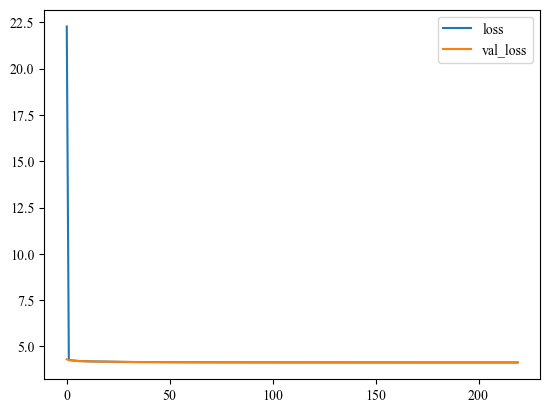

In [33]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [34]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["loss"].min()))

Minimum validation loss: 62.14398956298828


In [35]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((tracks_scaled,b_jets_scaled),bhads_targets,verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

2130/2130 - 7s - loss: 62.2160 - Mean_Squared_Error: 11511277568.0000 - 7s/epoch - 3ms/step
The Loaded DeepNet has loss:  [62.216007232666016, 11511277568.0]


In [37]:
Predictions = DeepSetProjector.predict((tracks_scaled, b_jets_scaled))
"""
Predictions_px = Predictions[:,0] * b_jets[:,0]
Predictions_py = Predictions[:,1] * b_jets[:,1]
Predictions_pz = Predictions[:,2] * b_jets[:,2]
Predictions_Projected = Predictions[:,3]
print(Predictions.shape)
"""
Predictions.shape

2130/2130 [==============================] - 7s 3ms/step


(68143, 45)

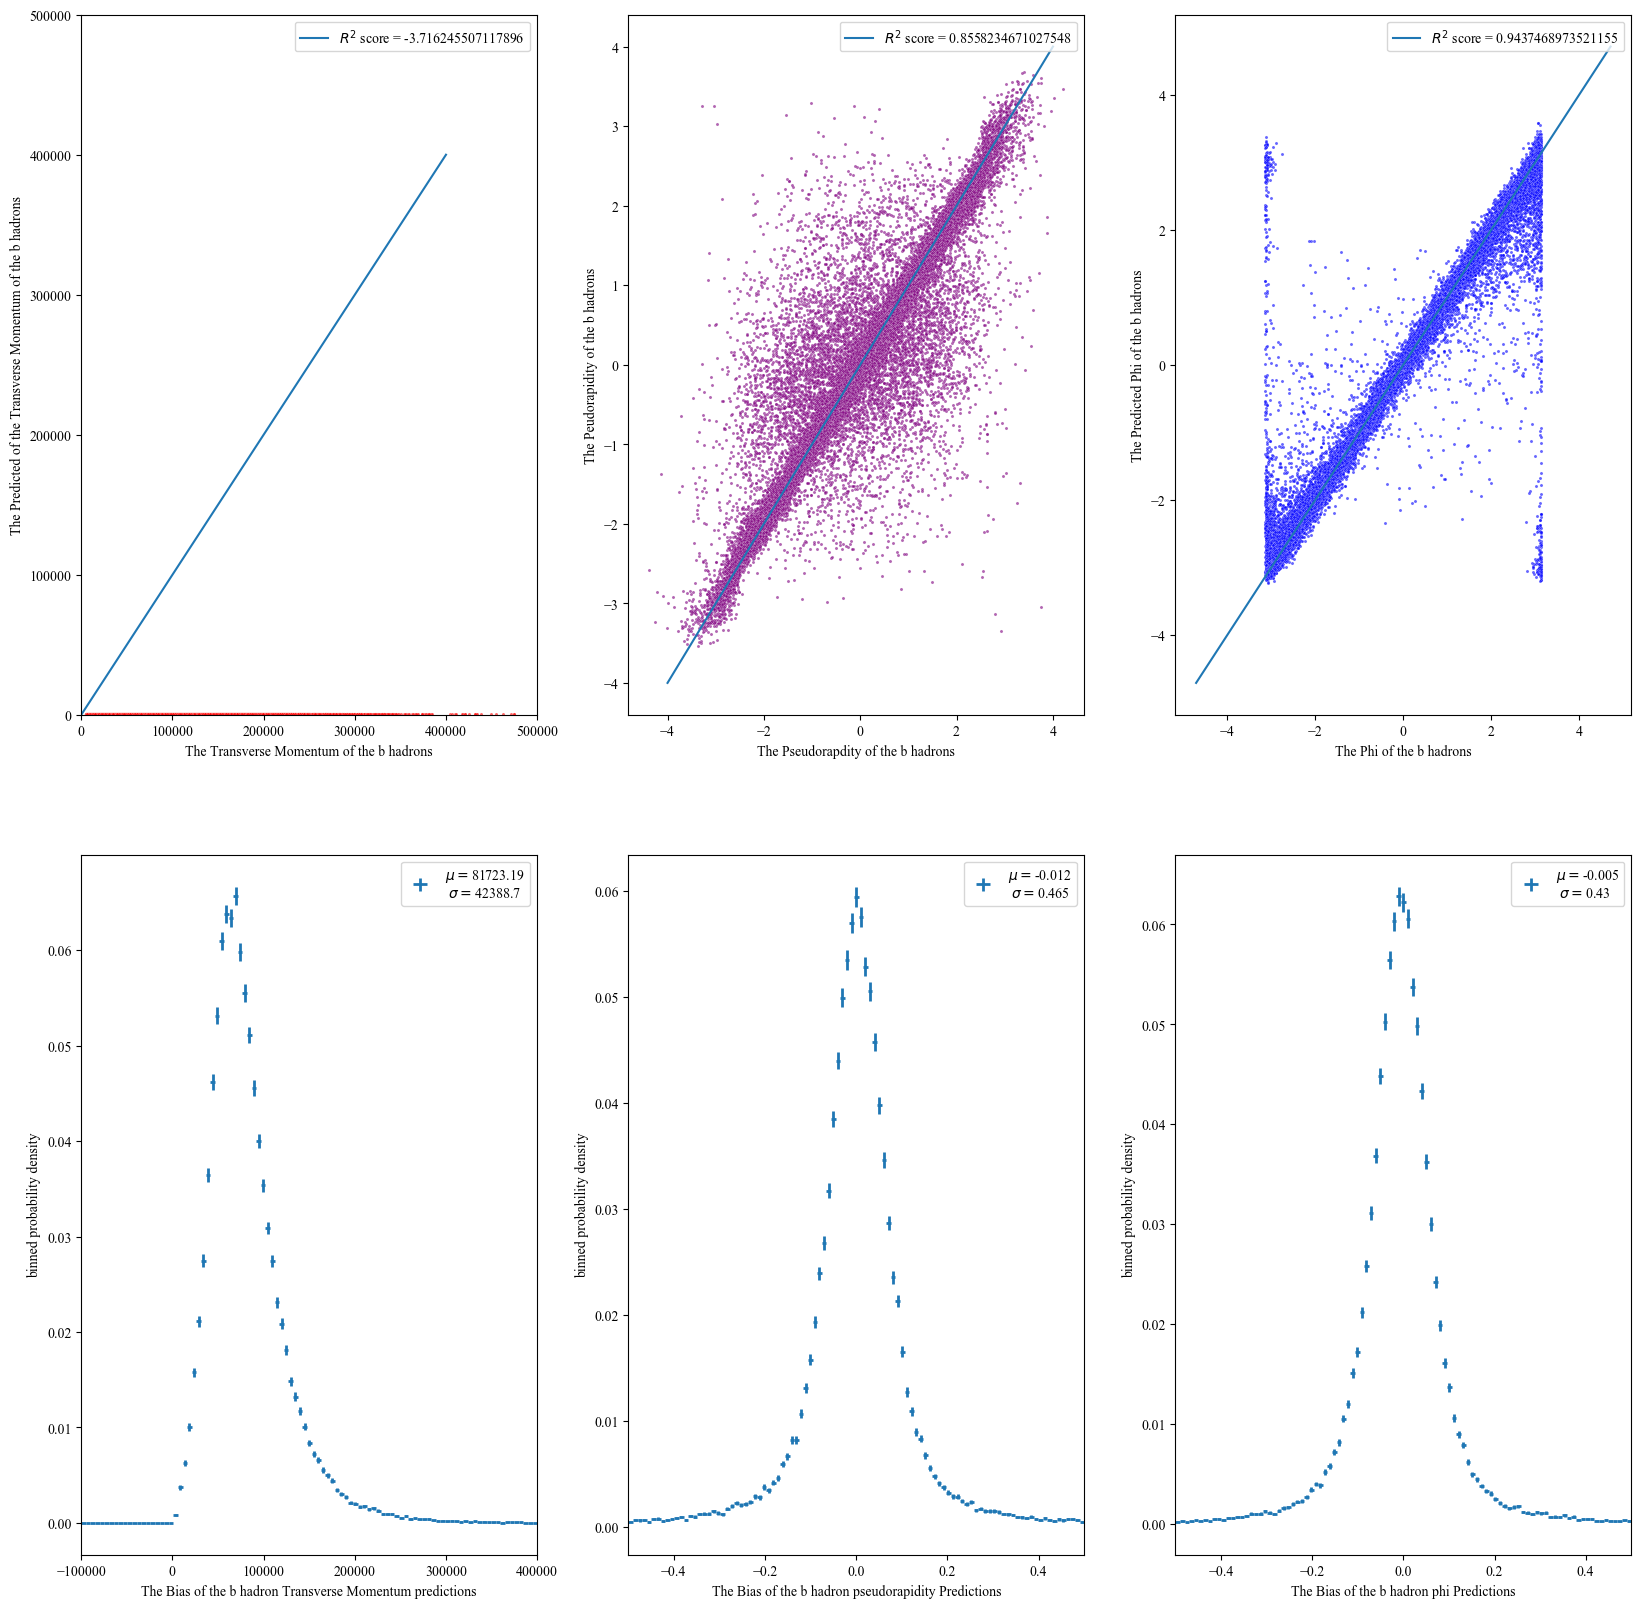

In [41]:
from sklearn.metrics import r2_score
from hffrag import binneddensitysub
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = sns.scatterplot(x = bhads_targets[:,3], y = Predictions[:,3], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1_score = r2_score(bhads_targets[:,3], Predictions[:,3])
x = np.linspace(0, 4e5)
l1.set_xlabel("The Transverse Momentum of the b hadrons")
l1.set_ylabel("The Predicted of the Transverse Momentum of the b hadrons")
error_pt = bhads_targets[:,3] - Predictions[:,3]
mean_error_pt, std_error_pt = np.mean(error_pt), np.std(error_pt)
l1.plot(x,x)
binneddensitysub(error_pt, fixedbinning(-1e5,4e5,100), ax = axes[1,0], xlabel= "The Bias of the b hadron Transverse Momentum predictions")
l2 = sns.scatterplot(x = bhads_targets[:,4], y = Predictions[:,4], ax = axes[0,1], s = 5, alpha = 0.6, color = "purple")
l2_score = r2_score(bhads_targets[:,4], Predictions[:,4])
x = np.linspace(-4, 4)
error_pseudorapidity = bhads_targets[:,4] - Predictions[:,4]
mean_error_pseudorapidity, std_error_psuedorapidity = np.mean(error_pseudorapidity), np.std(error_pseudorapidity)
l2.plot(x,x)
l2.set_xlabel("The Pseudorapdity of the b hadrons")
l2.set_ylabel("The Peudorapidity of the b hadrons")
binneddensitysub(error_pseudorapidity, fixedbinning(-0.5,0.5,100), ax = axes[1,1], xlabel="The Bias of the b hadron pseudorapidity Predictions")
l3 = sns.scatterplot(x = bhads_targets[:,5], y = Predictions[:,5], ax = axes[0,2], s = 5, alpha = 0.6, color = "blue")
l3_score = r2_score(bhads_targets[:,5], Predictions[:,5])
x = np.linspace(-1.5*np.pi, 1.5*np.pi)
error_phi = bhads_targets[:,5] - Predictions[:,5]
mean_error_phi, std_error_phi = np.mean(error_phi), np.std(error_phi)
l3.plot(x,x)
l3.set_xlabel("The Phi of the b hadrons")
l3.set_ylabel("The Predicted Phi of the b hadrons")
binneddensitysub(error_phi, fixedbinning(-0.5,0.5,100), ax = axes[1,2], xlabel="The Bias of the b hadron phi Predictions")
axes[0,0].set_ylim(0,5e5)
axes[0,0].legend([f"$R^2$ score = {l1_score}"], loc = "upper right")
axes[0,0].set_xlim(0,5e5)
axes[1,0].set_xlim(-1e5,4e5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt,2)}\n $\sigma = ${round(std_error_pt,2)}"], loc = "upper right")
axes[0,1].legend([f"$R^2$ score = {l2_score}"], loc = "upper right")
axes[1,1].set_xlim(-0.5,0.5)
axes[1,1].legend([f"$\mu = ${round(mean_error_pseudorapidity,3)}\n $\sigma = ${round(std_error_psuedorapidity,3)}"], loc = "upper right")
axes[0,2].legend([f"$R^2$ score = {l3_score}"], loc = "upper right")
axes[1,2].legend([f"$\mu = ${round(mean_error_phi,3)}\n $\sigma = ${round(std_error_phi,3)}"], loc = "upper right")
axes[1,2].set_xlim(-0.5,0.5)
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJets.png", dpi = 500)

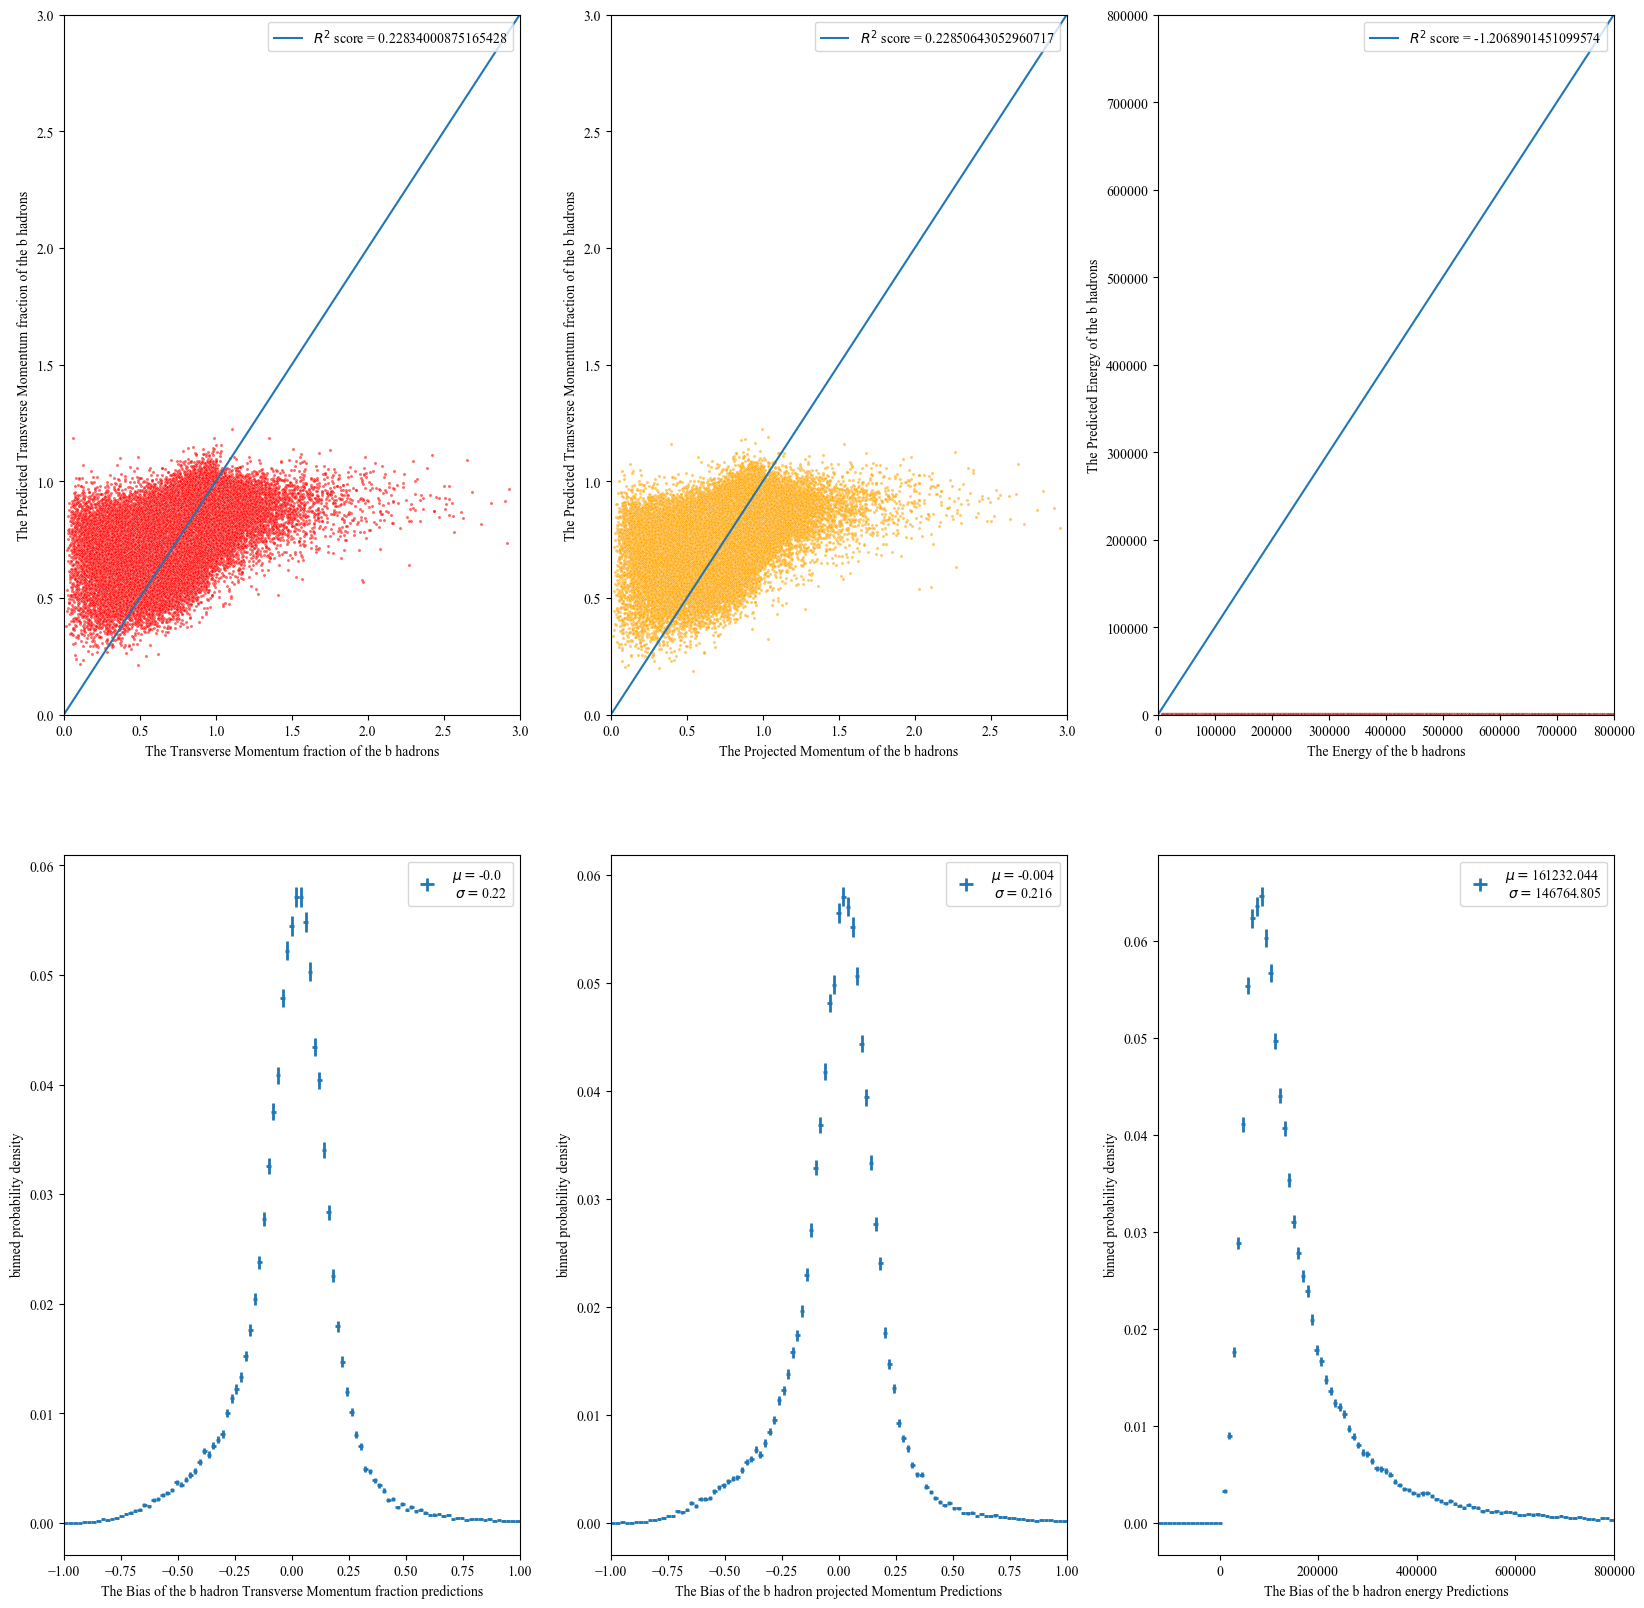

In [43]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = sns.scatterplot(x = bhads_targets[:,6], y = Predictions[:,6], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1_score = r2_score(bhads_targets[:,6], Predictions[:,6])
x = np.linspace(0, 4)
l1.set_xlabel("The Transverse Momentum fraction of the b hadrons")
l1.set_ylabel("The Predicted Transverse Momentum fraction of the b hadrons")
error_pt_fraction = bhads_targets[:,6] - Predictions[:,6]
mean_error_pt_fraction, std_error_pt_fraction = np.mean(error_pt_fraction), np.std(error_pt_fraction)
l1.plot(x,x)
binneddensitysub(error_pt_fraction, fixedbinning(-1,1,100), ax = axes[1,0], xlabel= "The Bias of the b hadron Transverse Momentum fraction predictions")
l2 = sns.scatterplot(x = bhads_targets[:,7], y = Predictions[:,7], ax = axes[0,1], s = 5, alpha = 0.6, color = "orange")
l2_score = r2_score(bhads_targets[:,7], Predictions[:,7])
x = np.linspace(0, 4)
error_projection = bhads_targets[:,7] - Predictions[:,7]
mean_error_projection, std_error_projection = np.mean(error_projection), np.std(error_projection)
l2.plot(x,x)
l2.set_xlabel("The Projected Momentum of the b hadrons")
l2.set_ylabel("The Predicted Transverse Momentum fraction of the b hadrons")
binneddensitysub(error_projection, fixedbinning(-1,1,100), ax = axes[1,1], xlabel="The Bias of the b hadron projected Momentum Predictions")
l3 = sns.scatterplot(x = bhads_targets[:,8], y = Predictions[:,8], ax = axes[0,2], s = 5, alpha = 0.6, color = "brown")
l3_score = r2_score(bhads_targets[:,8], Predictions[:,8])
x = np.linspace(0, 3e6)
error_energy = bhads_targets[:,8] - Predictions[:,8]
mean_error_energy, std_error_energy = np.mean(error_energy), np.std(error_energy)
l3.plot(x,x)
l3.set_xlabel("The Energy of the b hadrons")
l3.set_ylabel("The Predicted Energy of the b hadrons")
binneddensitysub(error_energy, fixedbinning(-1.25e5,8e5,100), ax = axes[1,2], xlabel="The Bias of the b hadron energy Predictions")
axes[0,0].set_ylim(0,3)
axes[0,0].legend([f"$R^2$ score = {l1_score}"], loc = "upper right")
axes[0,0].set_xlim(0,3)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt_fraction,2)}\n $\sigma = ${round(std_error_pt_fraction,2)}"], loc = "upper right")
axes[0,1].set_xlim(0,3)
axes[0,1].set_ylim(0,3)
axes[0,1].legend([f"$R^2$ score = {l2_score}"], loc = "upper right")
axes[1,1].legend([f"$\mu = ${round(mean_error_projection,3)}\n $\sigma = ${round(std_error_projection,3)}"], loc = "upper right")
axes[0,2].legend([f"$R^2$ score = {l3_score}"], loc = "upper right")
axes[1,2].legend([f"$\mu = ${round(mean_error_energy,3)}\n $\sigma = ${round(std_error_energy,3)}"], loc = "upper right")
axes[0,2].set_ylim(0,8e5)
axes[0,2].set_xlim(0,8e5)
axes[1,0].set_xlim(-1,1)
axes[1,1].set_xlim(-1,1)
axes[1,2].set_xlim(-1.25e5,8e5)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepJetsSets2.png", dpi = 500)

In [45]:
Error_pt = bhads_targets[:,3] - Predictions[:,3]
Pull_bhads_pt = Error_pt/np.std(bhads_targets[:,3])
Pull_pt = Error_pt/Predictions[:,12]
Pull_pt_mean, Pull_pt_std = np.mean(Pull_pt), np.std(Pull_pt)

In [46]:
Error_eta = bhads_targets[:,4] - Predictions[:,4]
Pull_bhads_eta = Error_eta/np.std(bhads_targets[:,4])
Pull_eta = Error_eta/Predictions[:,13]
Pull_eta_mean, Pull_eta_std = np.mean(Pull_eta), np.std(Pull_eta)

In [47]:
Error_phi = bhads_targets[:,5] - Predictions[:,5]
Pull_bhads_phi = Error_phi/np.std(bhads_targets[:,5])
Pull_phi = Error_phi/Predictions[:,14]
Pull_phi_mean, Pull_phi_std = np.mean(Pull_phi), np.std(Pull_phi)

In [48]:
Error_pt_fraction = bhads_targets[:,6] - Predictions[:,6]
Pull_bhads_pt_fraction = Error_pt_fraction/np.std(bhads_targets[:,6])
Pull_pt_fraction = Error_pt_fraction/Predictions[:,15]
Pull_pt_mean_fraction, Pull_pt_std_fraction = np.mean(Pull_bhads_pt_fraction), np.std(Pull_pt_fraction)

In [49]:
Error_projection = bhads_targets[:,7] - Predictions[:,7]
Pull_bhads_projection = Error_projection/np.std(bhads_targets[:,7])
Pull_projection = Error_projection/Predictions[:,16]
Pull_projection_mean, Pull_projection_std = np.mean(Pull_projection), np.std(Pull_projection)

In [50]:
Error_energy = bhads_targets[:,8] - Predictions[:,8]
Pull_bhads_energy = Error_energy/np.std(bhads_targets[:,8])
Pull_energy = Error_energy/Predictions[:,17]
Pull_energy_mean, Pull_energy_std = np.mean(Pull_energy), np.std(Pull_energy)

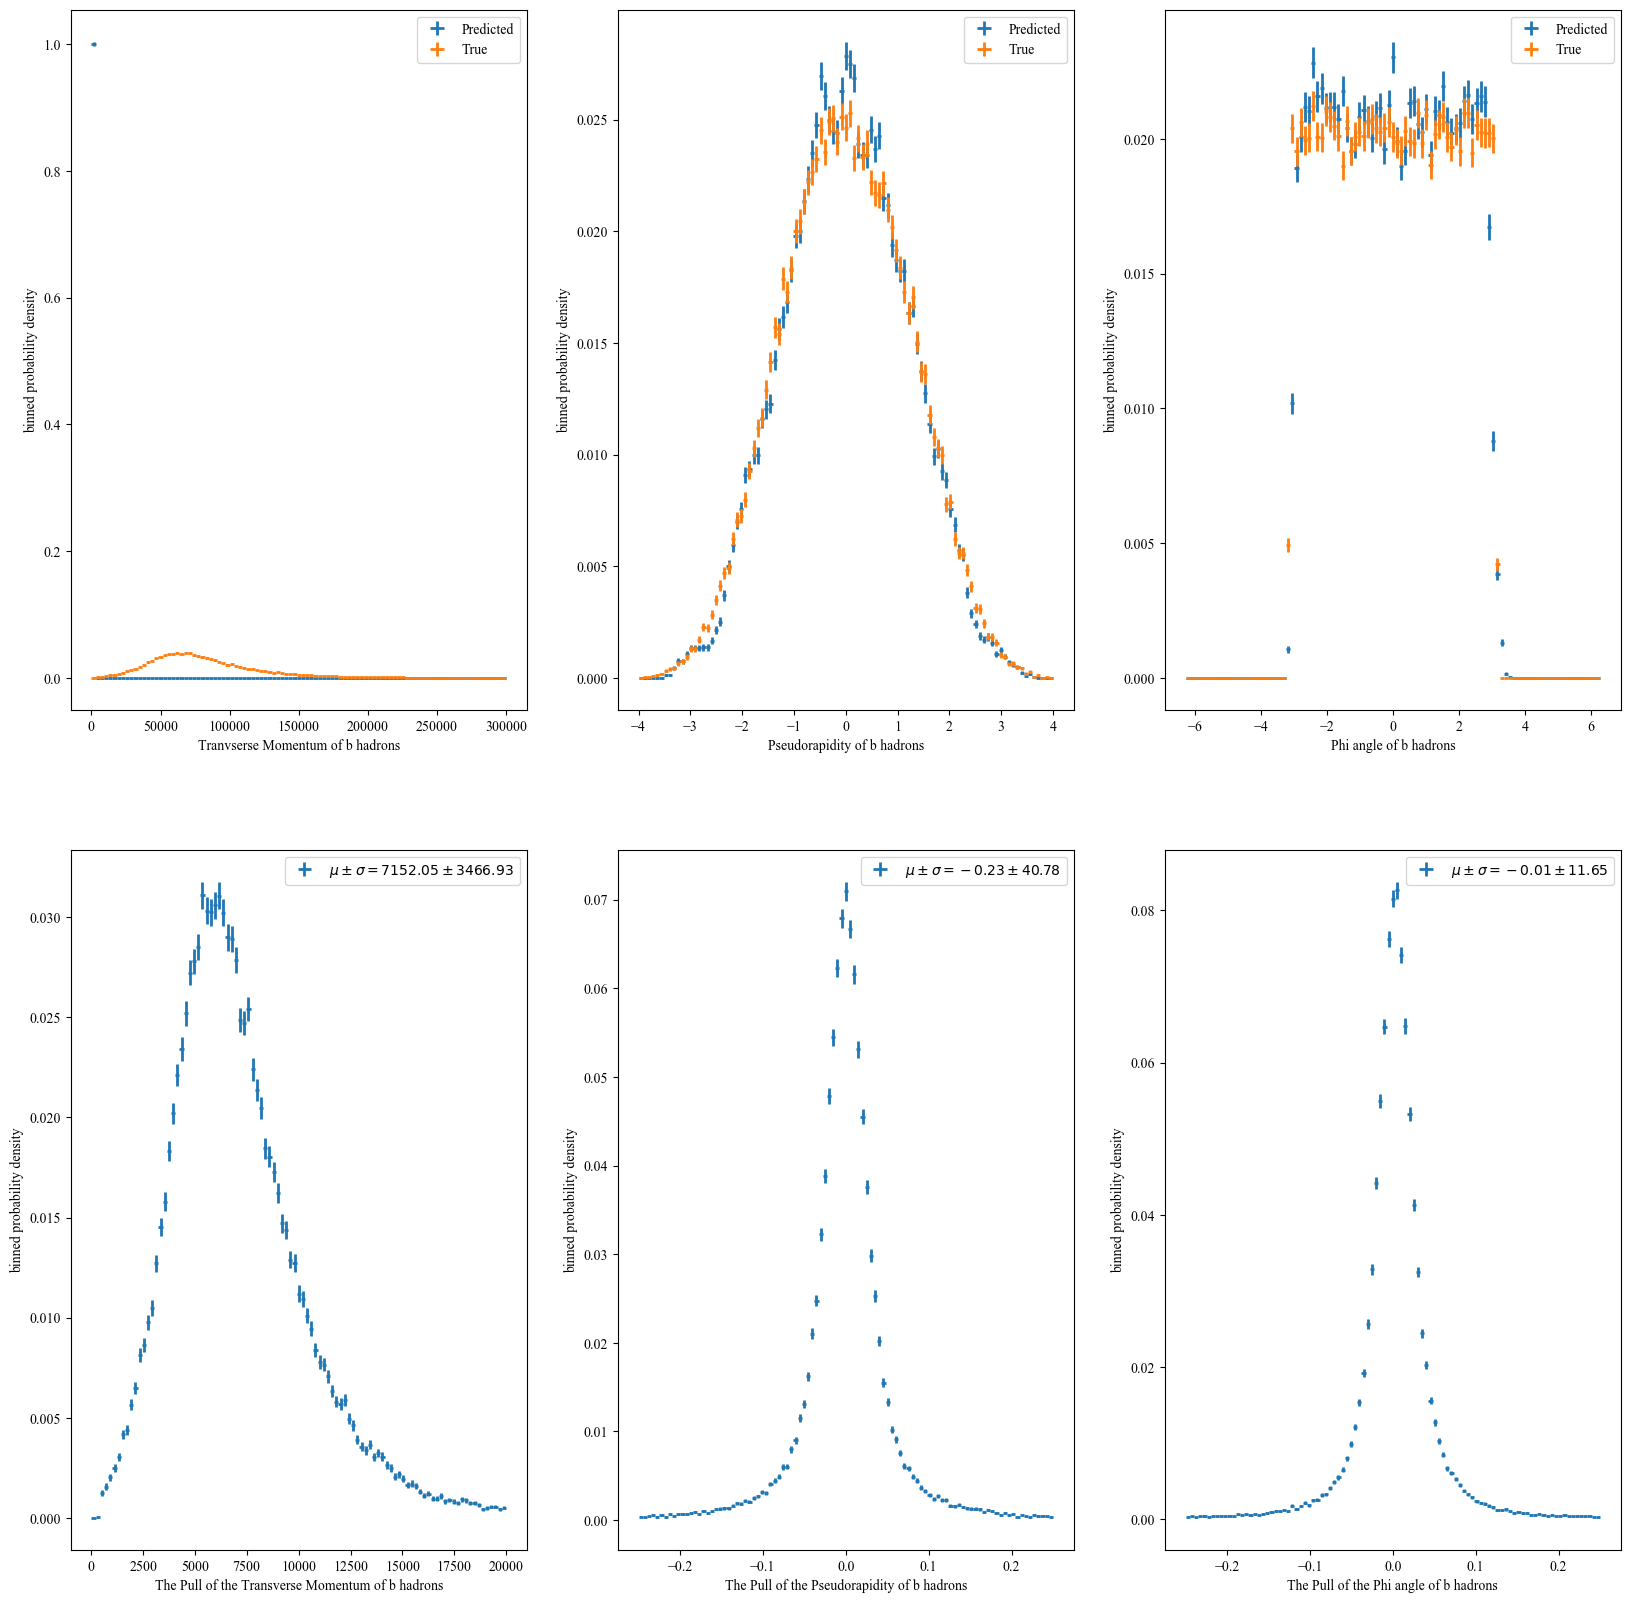

In [66]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = binneddensitysub(Predictions[:,3], fixedbinning(0,3e5,100), ax = axes[0,0], xlabel = "Predicted Tranvserse Momentum of b hadrons", label = "Predicted")
l2 = binneddensitysub(Predictions[:,4], fixedbinning(-4,4,100), ax = axes[0,1], xlabel = "Predicted Pseudorapidity Momentum of b hadrons", label = "Predicted")
l3 = binneddensitysub(Predictions[:,5], fixedbinning(-2*np.pi,2*np.pi,100), ax = axes[0,2], xlabel = "Predicted Phi Angle of b hadrons", label = "Predicted")
l4 = binneddensitysub(bhads_targets[:,3], fixedbinning(0,3e5,100), ax = axes[0,0], xlabel = "Tranvserse Momentum of b hadrons", label = "True")
l5 = binneddensitysub(bhads_targets[:,4], fixedbinning(-4, 4, 100), ax = axes[0,1], xlabel= "Pseudorapidity of b hadrons", label = "True")
l6 = binneddensitysub(bhads_targets[:,5], fixedbinning(-2*np.pi,2*np.pi,100), ax = axes[0,2], xlabel = "Phi angle of b hadrons", label = "True")
l7 = binneddensitysub(Pull_pt, fixedbinning(0,2e4,100), ax = axes[1,0], xlabel = "The Pull of the Transverse Momentum of b hadrons",)
l8 = binneddensitysub(Pull_eta, fixedbinning(-0.25,0.25,100), ax = axes[1,1], xlabel = "The Pull of the Pseudorapidity of b hadrons")
l9 = binneddensitysub(Pull_phi, fixedbinning(-0.25,0.25,100), ax = axes[1,2], xlabel = "The Pull of the Phi angle of b hadrons")
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean,2)} \pm {round(Pull_pt_std,2)}$"])
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_eta_mean,2)} \pm {round(Pull_eta_std,2)}$"])
axes[1,2].legend([f"$\mu \pm \sigma = {round(Pull_phi_mean,2)} \pm {round(Pull_phi_std,2)}$"])
axes[0,0].legend(loc = "upper right")
axes[0,1].legend(loc = "upper right")
axes[0,2].legend(loc = "upper right")
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepJetsSets4.png", dpi = 500)

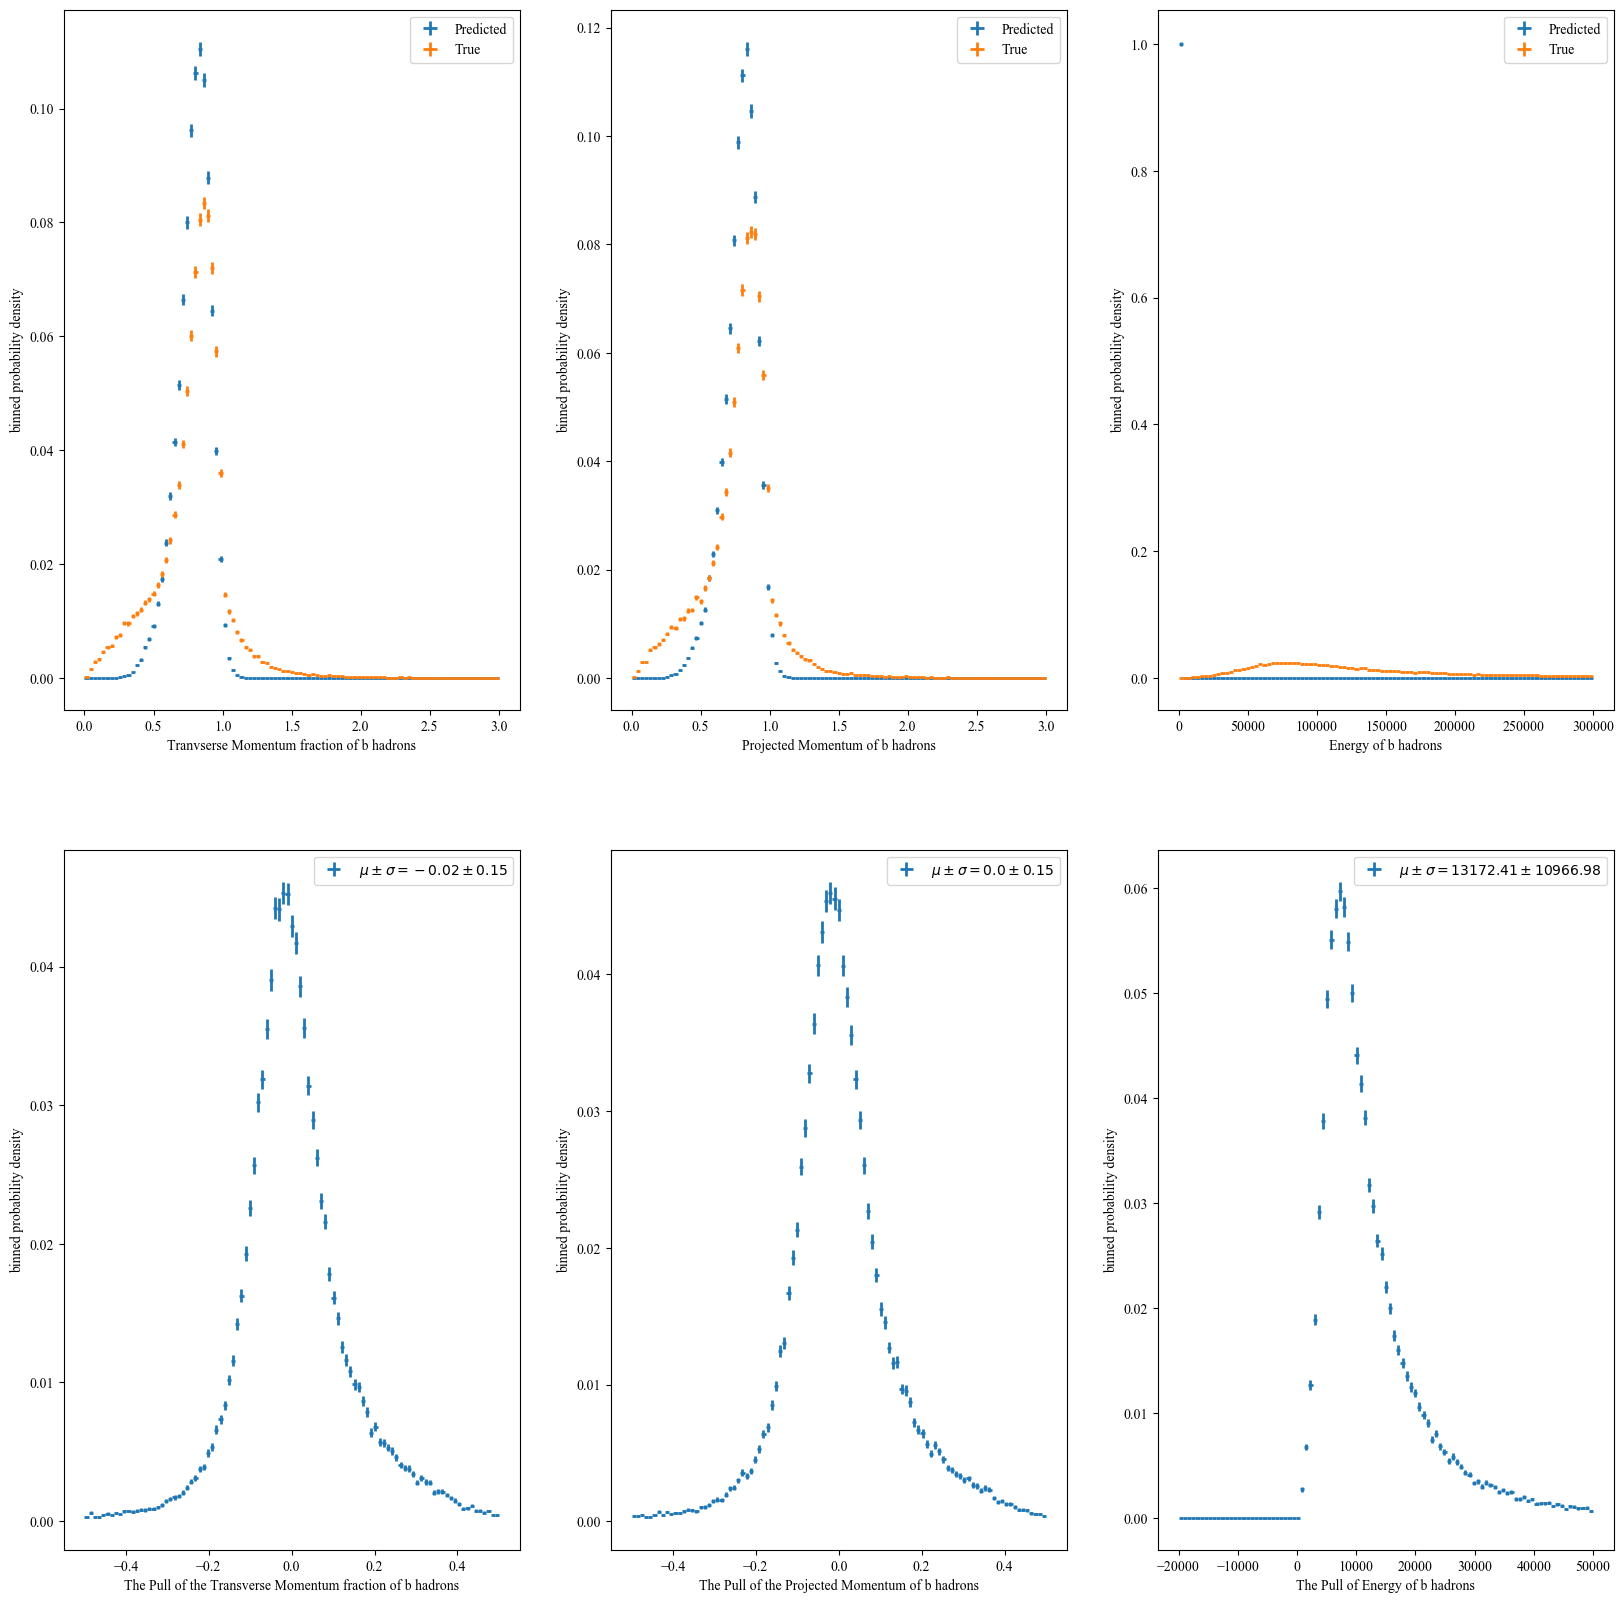

In [65]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = binneddensitysub(Predictions[:,6], fixedbinning(0,3,100), ax = axes[0,0], xlabel = "Predicted Tranvserse Momentum fraction of b hadrons", label = "Predicted")
l2 = binneddensitysub(Predictions[:,7], fixedbinning(0,3,100), ax = axes[0,1], xlabel = "Predicted Projected Momentum of b hadrons", label = "Predicted")
l3 = binneddensitysub(Predictions[:,8], fixedbinning(0,3e5,100), ax = axes[0,2], xlabel = "Predicted Energy of b hadrons", label = "Predicted")
l4 = binneddensitysub(bhads_targets[:,6], fixedbinning(0,3,100), ax = axes[0,0], xlabel = "Tranvserse Momentum fraction of b hadrons", label = "True")
l5 = binneddensitysub(bhads_targets[:,7], fixedbinning(0, 3, 100), ax = axes[0,1], xlabel= "Projected Momentum of b hadrons", label = "True")
l6 = binneddensitysub(bhads_targets[:,8], fixedbinning(0,3e5,100), ax = axes[0,2], xlabel = "Energy of b hadrons", label = "True")
l7 = binneddensitysub(Pull_pt_fraction, fixedbinning(-0.5,0.5,100), ax = axes[1,0], xlabel = "The Pull of the Transverse Momentum fraction of b hadrons",)
l8 = binneddensitysub(Pull_projection, fixedbinning(-0.5,0.5,100), ax = axes[1,1], xlabel = "The Pull of the Projected Momentum of b hadrons")
l9 = binneddensitysub(Pull_energy, fixedbinning(-2e4,5e4,100), ax = axes[1,2], xlabel = "The Pull of Energy of b hadrons")
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean_fraction,2)} \pm {round(Pull_pt_std_fraction,2)}$"])
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_projection_mean,2)} \pm {round(Pull_projection_std,2)}$"])
axes[1,2].legend([f"$\mu \pm \sigma = {round(Pull_energy_mean,2)} \pm {round(Pull_energy_std,2)}$"])
axes[0,0].legend(loc = "upper right")
axes[0,1].legend(loc = "upper right")
axes[0,2].legend(loc = "upper right")
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepJetsSets5.png", dpi = 500)

In [ ]:
Error_px = bhads[:,0] - Predictions_px
Pull_bhads_px = Error_px/np.std(bhads[:,0])

In [ ]:
Error_py = bhads[:,1] - Predictions_py
Pull_bhads_py = Error_py/np.std(bhads[:,1])

In [ ]:
Error_pz = bhads[:,2] - Predictions_pz
Pull_bhads_pz = Error_pz/np.std(bhads[:,2])

In [ ]:
Error_projection = bhads_targets[:,-1] - Predictions_Projected
Pull_bhads_pz = Error_pz/np.std(bhads_targets[:,-1])

In [ ]:
print(np.mean(Error_px))
print(np.std(Error_px))
binneddensity(Error_px, fixedbinning(-40000,40000,100),xlabel = "Error_px")

In [ ]:
print(np.mean(Error_py))
print(np.std(Error_py))
binneddensity(Error_py, fixedbinning(-40000,40000,100),xlabel = "Error_py")

In [ ]:
print(np.mean(Error_pz))
print(np.std(Error_pz))
binneddensity(Error_pz, fixedbinning(-40000,40000,100),xlabel = "Error_pz")

In [ ]:
print(np.mean(Error_projection))
print(np.std(Error_projection))
binneddensity(Error_projection, fixedbinning(-1,1,100),xlabel = "Error_projection")

In [ ]:
print(np.mean(Pull_bhads_px))
print(np.std(Pull_bhads_px))
binneddensity(Pull_bhads_px, fixedbinning(-1,1,100),xlabel = "Pull_px")

In [ ]:
print(np.mean(Pull_bhads_py))
print(np.std(Pull_bhads_py))
binneddensity(Pull_bhads_py, fixedbinning(-1,1,100),xlabel = "Pull_py")

In [ ]:
print(np.mean(Pull_bhads_pz))
print(np.std(Pull_bhads_pz))
binneddensity(Pull_bhads_pz, fixedbinning(-100000,100000,100),xlabel = "Pull_pz")

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_px,
    x = bhads[:,0],
    color = "blue"
)
ax.set_xlim([-400000,400000])
ax.set_ylim([-400000,400000])
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_py,
    x = bhads[:,1],
    color = "green"
)
ax.set_xlim([-400000,400000])
ax.set_ylim([-400000,400000])
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_pz,
    x = bhads[:,2],
    color = "orange"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

In [ ]:
Predictions_cart = np.stack([Predictions_px, Predictions_py, Predictions_pz], axis = -1)
Predictions_Projection = ((Predictions_cart*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_Projection,
    x = bhads_projection,
    color = "orange"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

In [ ]:
print(np.mean(Predictions_Projection))
print(np.std(Predictions_Projection))
binneddensity(Predictions_Projection, fixedbinning(0,2,100),xlabel = "Plot")